In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error,mean_squared_error
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings("ignore")

### dict_keys(['S&P', 'NYA', 'DJI', 'RUT', 'NASDAQ'])

# For S&P data 

## For 60 Days

In [3]:
DATADIR = "/content/"
TRAIN_TEST_CUTOFF = '2016-04-21'
TRAIN_VALID_RATIO = 0.75

# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# to implement F1 score for validation in a batch
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

def lstm_model(seq_len=60, n_features=82):
    "2D-CNNpred model according to the paper"
    model = Sequential([
        Input(shape=(seq_len,n_features)),
        #Conv2D(8, kernel_size=(1, n_features), activation="relu"),
        #MaxPool2D(pool_size=(2,1)),
        #Flatten(),
        LSTM(32, activation="relu",return_sequences=True),
        Dropout(0.4),
        LSTM(16, activation="relu"),
        Dropout(0.4),
        Dense(16,activation="relu"),
        #Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])
    return model

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def datagen(data, seq_len, batch_size, targetcol, kind, key):
    "As a generator to produce samples for Keras model"
    batch = []
    while True:
        # Pick one dataframe from the pool
        #key = random.choice(list(data.keys()))
        df = data[key]
        input_cols = [c for c in df.columns if c != targetcol]
        index = df.index[df.index < TRAIN_TEST_CUTOFF]
        split = int(len(index) * TRAIN_VALID_RATIO)
        assert split > seq_len, "Training data too small for sequence length {}".format(seq_len)
        if kind == 'train':
            index = index[:split]   # range for the training set
        elif kind == 'valid':
            index = index[split:]   # range for the validation set
        else:
            raise NotImplementedError
        # Pick one position, then clip a sequence length
        while True:
            t = random.choice(index)     # pick one time step
            n = (df.index == t).argmax() # find its position in the dataframe
            if n-seq_len+1 < 0:
                continue # this sample is not enough for one sequence length
            frame = df.iloc[n-seq_len+1:n+1]
            batch.append([frame[input_cols].values, df.loc[t, targetcol]])
            break
        # if we get enough for a batch, dispatch
        if len(batch) == batch_size:
            X, y = zip(*batch)
            X, y = np.expand_dims(np.array(X), 3), np.array(y)
            yield X.reshape((X.shape[0],X.shape[1],82)), y.astype(np.float)
            batch = []

def testgen(data, seq_len, targetcol, key):
    "Return array of all test samples"
    batch = []
    df = data[key]
    #for key, df in data.items():
    input_cols = [c for c in df.columns if c != targetcol]
    # find the start of test sample
    t = df.index[df.index >= TRAIN_TEST_CUTOFF][0]
    n = (df.index == t).argmax()
    # extract sample using a sliding window
    for i in range(n+1, len(df)+1):
        frame = df.iloc[i-seq_len:i]
        batch.append([frame[input_cols].values, frame[targetcol][-1]])
    X, y = zip(*batch)
    #return np.expand_dims(np.array(X),3), np.array(y)
    X, y = np.expand_dims(np.array(X), 3), np.array(y)
    #print(X.shape)
    return X.reshape((X.shape[0],X.shape[1],82)), y.astype(np.float)

# Read data into pandas DataFrames
data = {}
for filename in os.listdir('/content/'):
    if not filename.lower().endswith(".csv"):
        continue # read only the CSV files
    filepath = os.path.join('/content/', filename)
    X = pd.read_csv(filepath, index_col="Date", parse_dates=True)
    # basic preprocessing: get the name, the classification
    # Save the target variable as a column in dataframe for easier dropna()
    name = X["Name"][0]
    del X["Name"]
    cols = X.columns
    X["Target"] = (X["Close"].pct_change().shift(-1) > 0).astype(int)
    X.dropna(inplace=True)
    # Fit the standard scaler using the training dataset
    index = X.index[X.index < TRAIN_TEST_CUTOFF]
    index = index[:int(len(index) * TRAIN_VALID_RATIO)]
    scaler = StandardScaler().fit(X.loc[index, cols])
    # Save scale transformed dataframe
    X[cols] = scaler.transform(X[cols])
    data[name] = X

seq_len = 60
batch_size = 128
n_epochs = 5
n_features = 82


# Define AUC
Aucroc = tf.keras.metrics.AUC(curve="ROC")
# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","S&P"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","S&P"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "S&P")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 32)            14720     
                                                                 
 dropout (Dropout)           (None, 60, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-traina

In [4]:
def plot_loss(train_loss,val_loss):
  loss_train = history.history[train_loss]
  loss_val = history.history[val_loss]
  plt.plot(loss_train, 'g', label='Training Loss')
  plt.plot(loss_val, 'b', label='validation Loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [5]:
def plot_accuracy(acc_train,acc_val):
  acc_train = history.history[acc_train]
  acc_val = history.history[acc_val]
  plt.plot(acc_train, 'g', label='Training Accuracy')
  plt.plot(acc_val, 'b', label='validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [6]:
def plot_f1macro(f1_train,f1_val):
  f1_train = history.history[f1_train]
  f1_val = history.history[f1_val]
  plt.plot(f1_train, 'g', label='Training F1macro')
  plt.plot(f1_val, 'b', label='validation F1macro')
  plt.title('Training and Validation F1macro')
  plt.xlabel('Epochs')
  plt.ylabel('F1macro')
  plt.legend()
  plt.show()

In [7]:
def plot_Aucroc(auc_train,auc_val):
  aucroc_train = history.history[auc_train]
  aucroc_val = history.history[auc_val]
  plt.plot(aucroc_train, 'g', label='Training AucRoc')
  plt.plot(aucroc_val, 'b', label='validation AucRoc')
  plt.title('Training and Validation AucRoc')
  plt.xlabel('Epochs')
  plt.ylabel('AUC')
  plt.legend()
  plt.show()

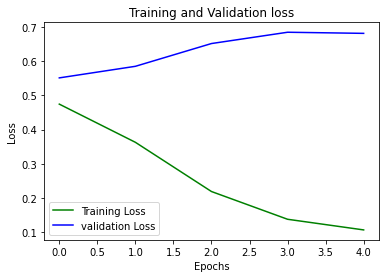

In [8]:
plot_loss('loss','val_loss')

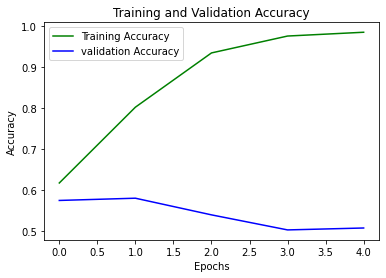

In [9]:
plot_accuracy('acc','val_acc')

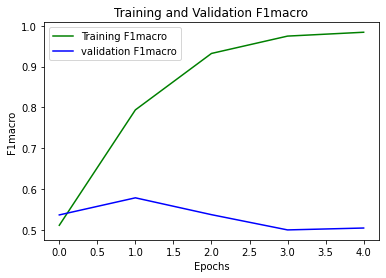

In [10]:
plot_f1macro('f1macro','val_f1macro')

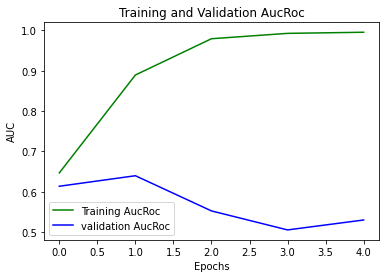

In [11]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [12]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","S&P"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","S&P"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "S&P")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 32)            14720     
                                                                 
 dropout_2 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

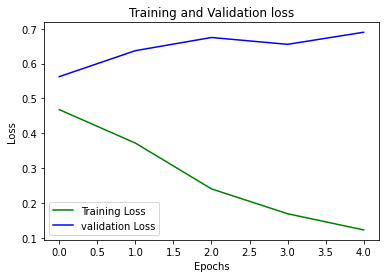

In [13]:
plot_loss('loss','val_loss')

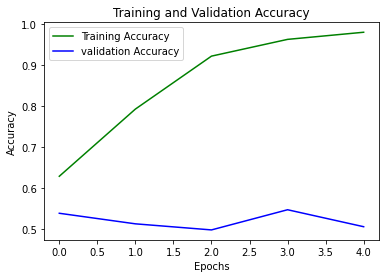

In [14]:
plot_accuracy('acc','val_acc')

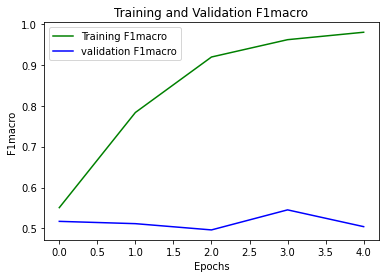

In [15]:
plot_f1macro('f1macro','val_f1macro')

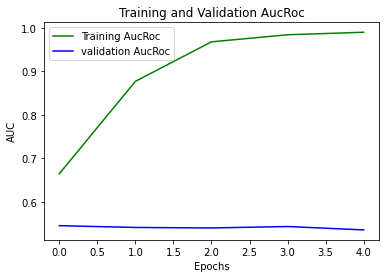

In [16]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [17]:
# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","S&P"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","S&P"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "S&P")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 32)            14720     
                                                                 
 dropout_4 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

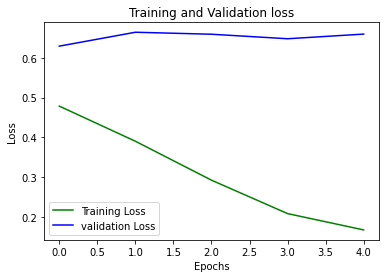

In [18]:
plot_loss('loss','val_loss')

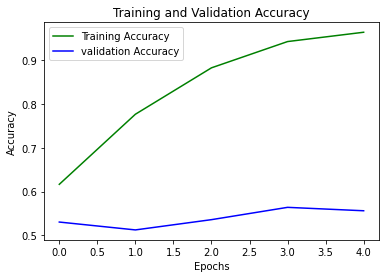

In [19]:
plot_accuracy('acc','val_acc')

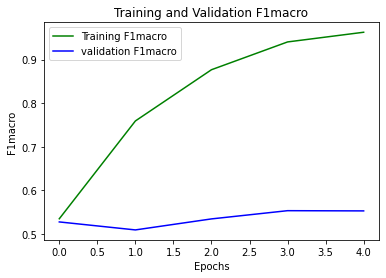

In [20]:
plot_f1macro('f1macro','val_f1macro')

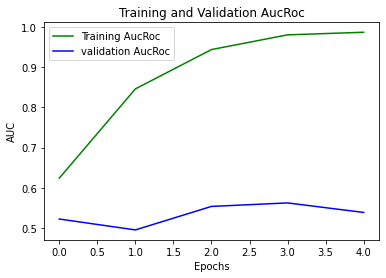

In [21]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [22]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","S&P"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","S&P"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "S&P")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 32)            14720     
                                                                 
 dropout_6 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_7 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

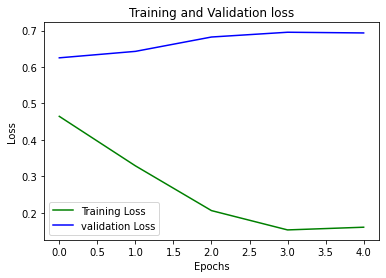

In [23]:
plot_loss('loss','val_loss')

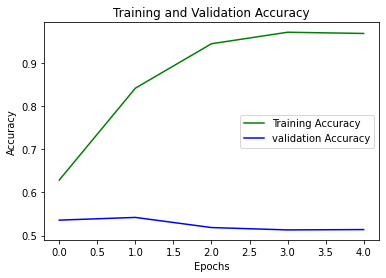

In [24]:
plot_accuracy('acc','val_acc')

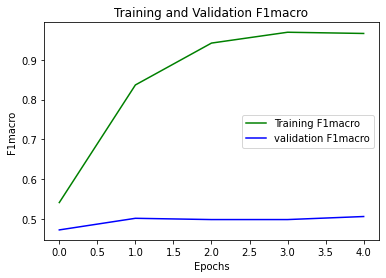

In [25]:
plot_f1macro('f1macro','val_f1macro')

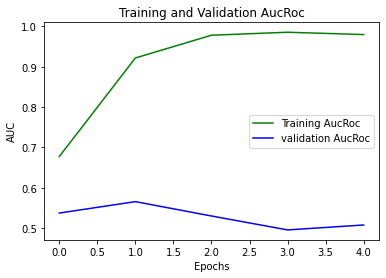

In [26]:
plot_Aucroc('auc','val_auc')

# For NYA

## For 60 Days

In [27]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","NYA"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","NYA"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "NYA")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 32)            14720     
                                                                 
 dropout_8 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_9 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

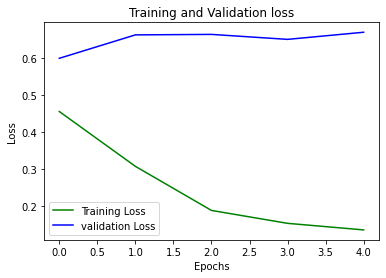

In [28]:
plot_loss('loss','val_loss')

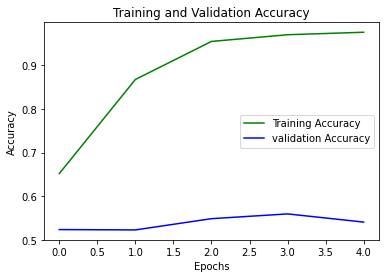

In [29]:
plot_accuracy('acc','val_acc')

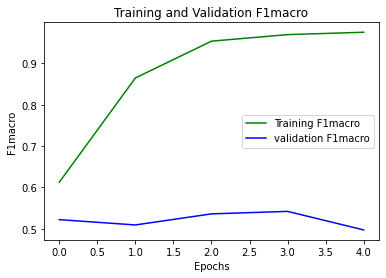

In [30]:
plot_f1macro('f1macro','val_f1macro')

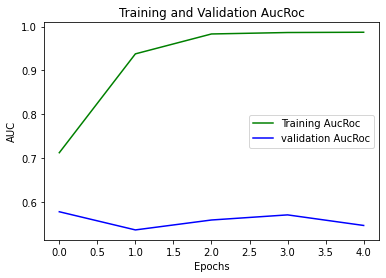

In [31]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [32]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","NYA"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","NYA"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "NYA")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 32)            14720     
                                                                 
 dropout_10 (Dropout)        (None, 30, 32)            0         
                                                                 
 lstm_11 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

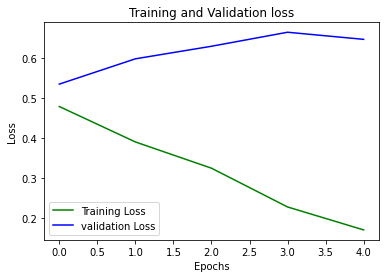

In [33]:
plot_loss('loss','val_loss')

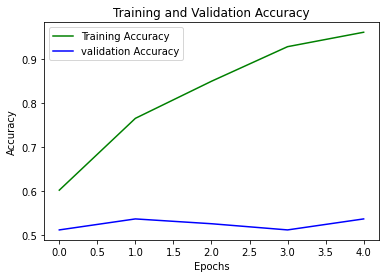

In [34]:
plot_accuracy('acc','val_acc')

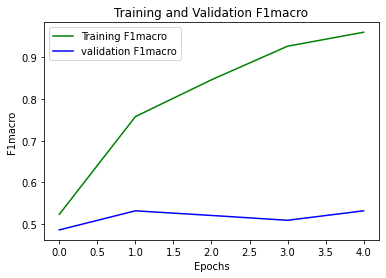

In [35]:
plot_f1macro('f1macro','val_f1macro')

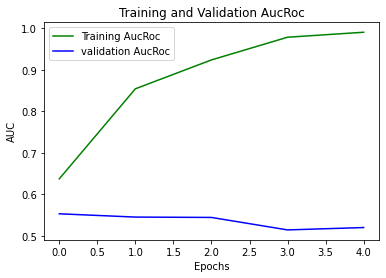

In [36]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [37]:
# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","NYA"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","NYA"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "NYA")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 32)            14720     
                                                                 
 dropout_12 (Dropout)        (None, 20, 32)            0         
                                                                 
 lstm_13 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

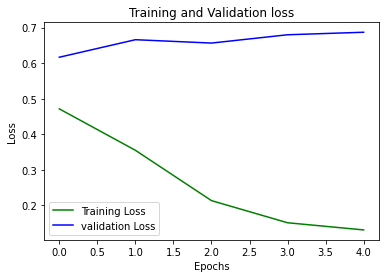

In [38]:
plot_loss('loss','val_loss')

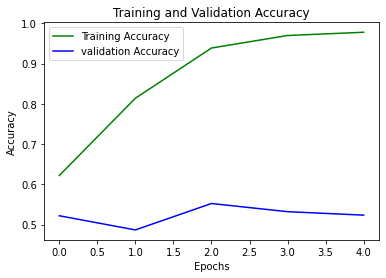

In [39]:
plot_accuracy('acc','val_acc')

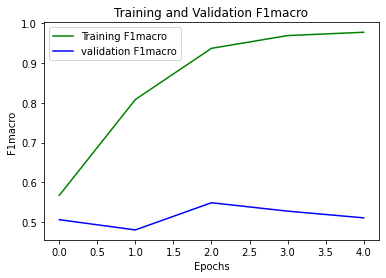

In [40]:
plot_f1macro('f1macro','val_f1macro')

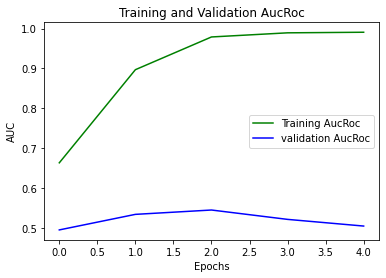

In [41]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [42]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","NYA"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","NYA"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "NYA")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10, 32)            14720     
                                                                 
 dropout_14 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_15 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

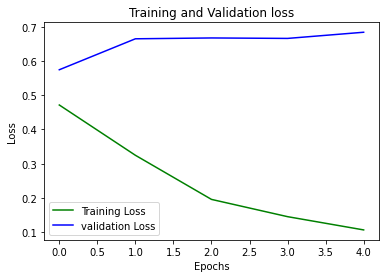

In [43]:
plot_loss('loss','val_loss')

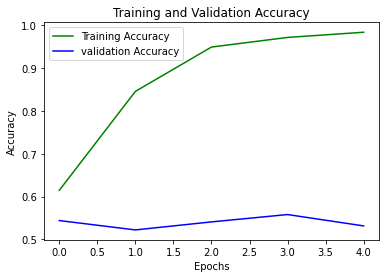

In [44]:
plot_accuracy('acc','val_acc')

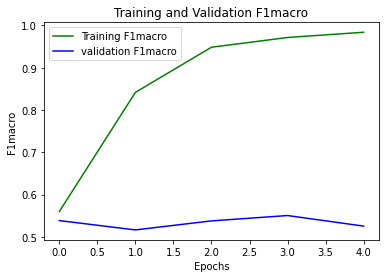

In [45]:
plot_f1macro('f1macro','val_f1macro')

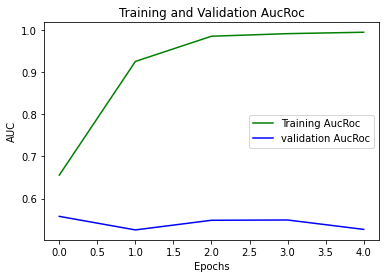

In [46]:
plot_Aucroc('auc','val_auc')

# For DJI

## For 60 Days

In [47]:
# For 60 days
seq_len = 60
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","DJI"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","DJI"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "DJI")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 32)            14720     
                                                                 
 dropout_16 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_17 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

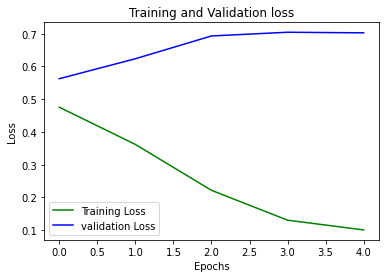

In [48]:
plot_loss('loss','val_loss')

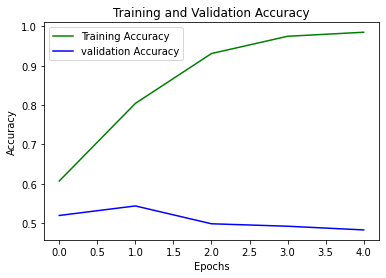

In [49]:
plot_accuracy('acc','val_acc')

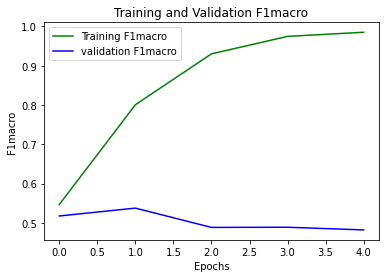

In [50]:
plot_f1macro('f1macro','val_f1macro')

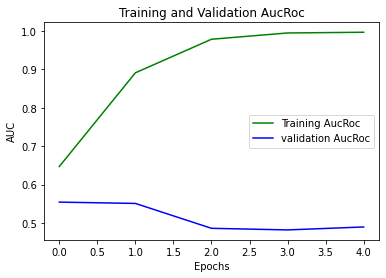

In [51]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [52]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","DJI"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","DJI"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "DJI")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 32)            14720     
                                                                 
 dropout_18 (Dropout)        (None, 30, 32)            0         
                                                                 
 lstm_19 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

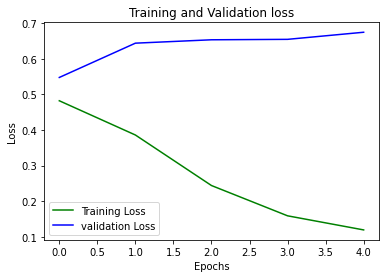

In [53]:
plot_loss('loss','val_loss')

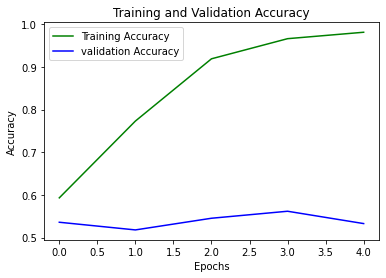

In [54]:
plot_accuracy('acc','val_acc')

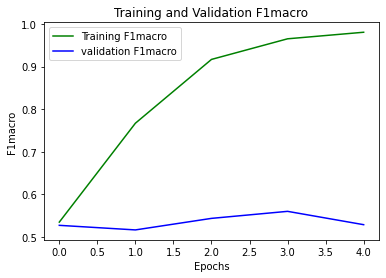

In [55]:
plot_f1macro('f1macro','val_f1macro')

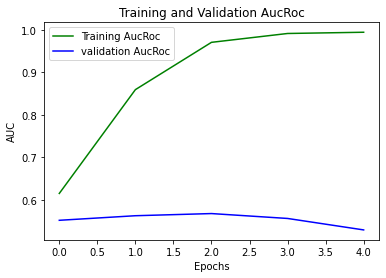

In [56]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [57]:
# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","DJI"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","DJI"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "DJI")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 20, 32)            14720     
                                                                 
 dropout_20 (Dropout)        (None, 20, 32)            0         
                                                                 
 lstm_21 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_21 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-tra

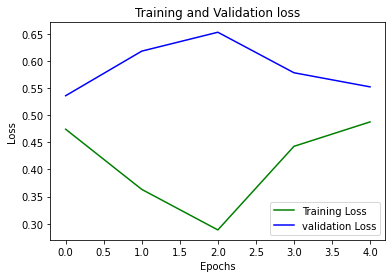

In [58]:
plot_loss('loss','val_loss')

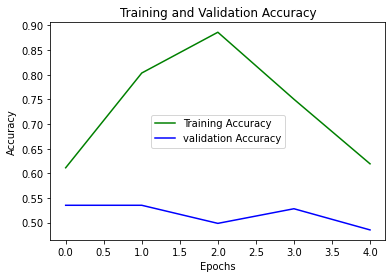

In [59]:
plot_accuracy('acc','val_acc')

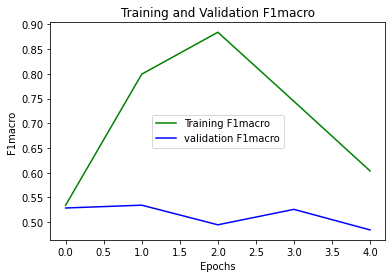

In [60]:
plot_f1macro('f1macro','val_f1macro')

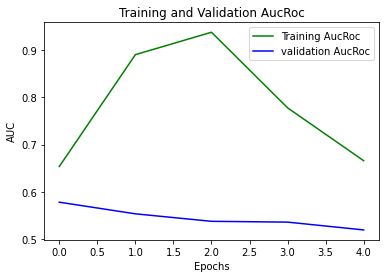

In [61]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [62]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","DJI"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","DJI"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "DJI")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 10, 32)            14720     
                                                                 
 dropout_22 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_23 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_23 (Dropout)        (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 16)                272       
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-tra

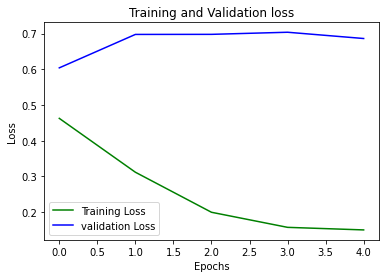

In [63]:
plot_loss('loss','val_loss')

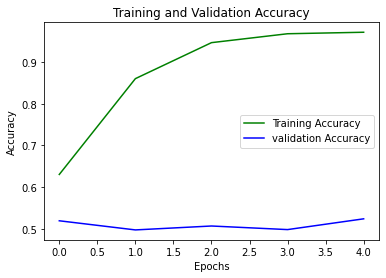

In [64]:
plot_accuracy('acc','val_acc')

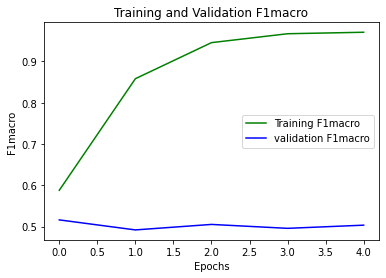

In [65]:
plot_f1macro('f1macro','val_f1macro')

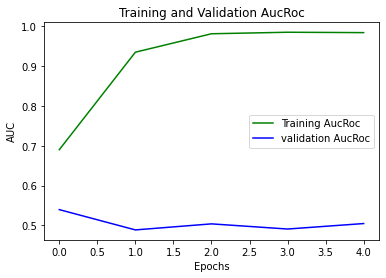

In [66]:
plot_Aucroc('auc','val_auc')

# For RUT

## For 60 Days

In [67]:
# For 60 days
seq_len = 60
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","RUT"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","RUT"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "RUT")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 32)            14720     
                                                                 
 dropout_24 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_25 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-tra

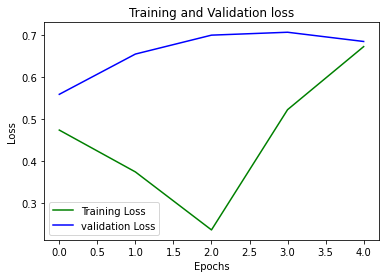

In [68]:
plot_loss('loss','val_loss')

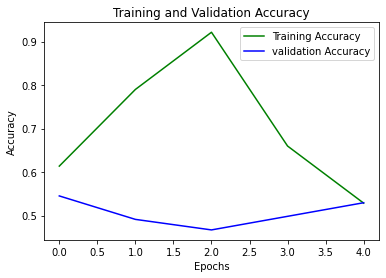

In [69]:
plot_accuracy('acc','val_acc')

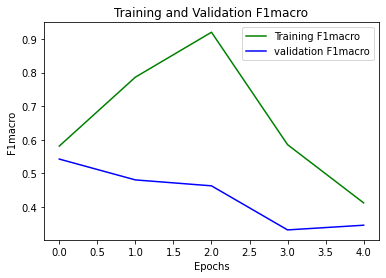

In [70]:
plot_f1macro('f1macro','val_f1macro')

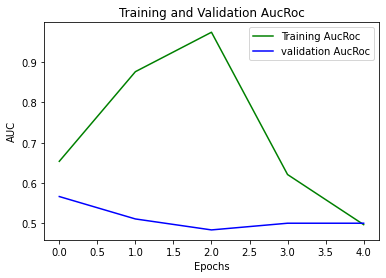

In [71]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [72]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","RUT"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","RUT"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "RUT")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 30, 32)            14720     
                                                                 
 dropout_26 (Dropout)        (None, 30, 32)            0         
                                                                 
 lstm_27 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_27 (Dropout)        (None, 16)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                272       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-tra

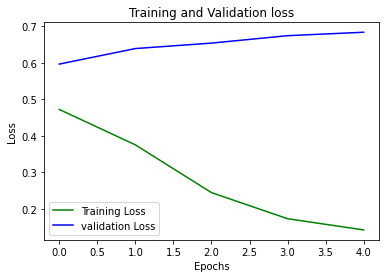

In [73]:
plot_loss('loss','val_loss')

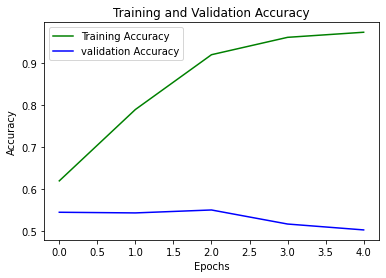

In [74]:
plot_accuracy('acc','val_acc')

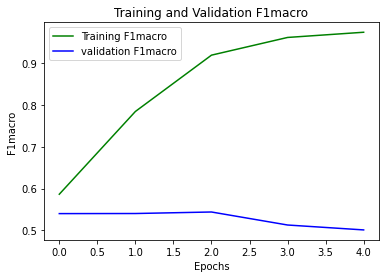

In [75]:
plot_f1macro('f1macro','val_f1macro')

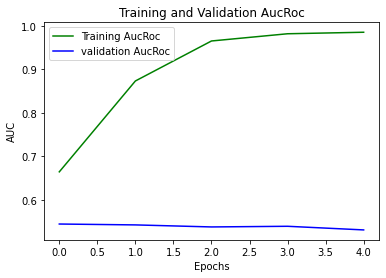

In [76]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [77]:
# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","RUT"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","RUT"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "RUT")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 20, 32)            14720     
                                                                 
 dropout_28 (Dropout)        (None, 20, 32)            0         
                                                                 
 lstm_29 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-tra

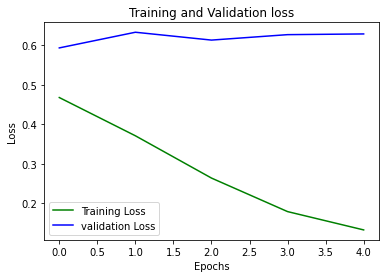

In [78]:
plot_loss('loss','val_loss')

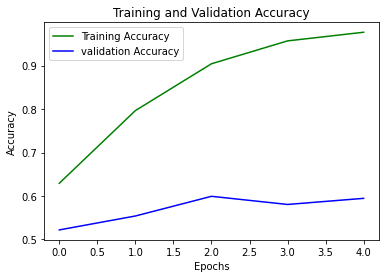

In [79]:
plot_accuracy('acc','val_acc')

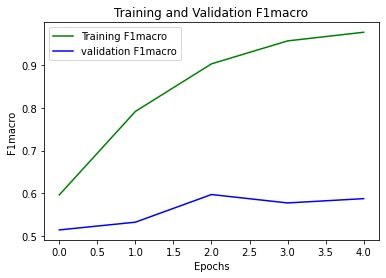

In [80]:
plot_f1macro('f1macro','val_f1macro')

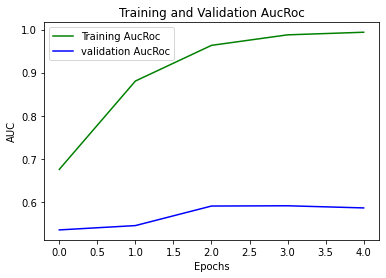

In [81]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [82]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","RUT"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","RUT"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "RUT")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 10, 32)            14720     
                                                                 
 dropout_30 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_31 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_31 (Dropout)        (None, 16)                0         
                                                                 
 dense_30 (Dense)            (None, 16)                272       
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-tra

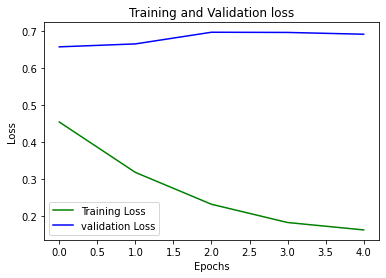

In [83]:
plot_loss('loss','val_loss')

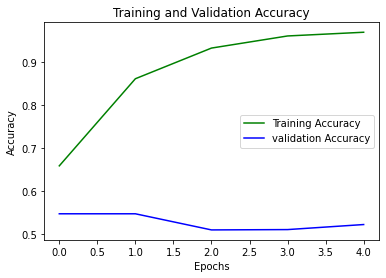

In [84]:
plot_accuracy('acc','val_acc')

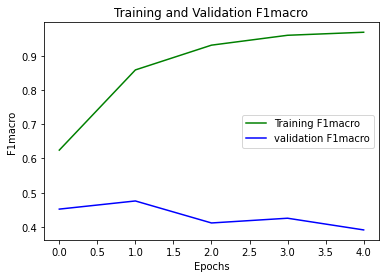

In [85]:
plot_f1macro('f1macro','val_f1macro')

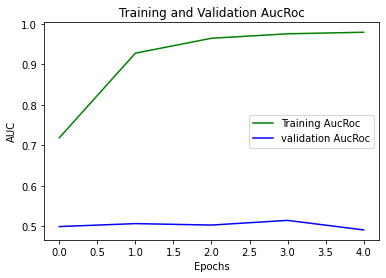

In [86]:
plot_Aucroc('auc','val_auc')

# For NASDAQ

# For 60 Days

In [87]:
# For 60 days
seq_len = 60
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","NASDAQ"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","NASDAQ"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "NASDAQ")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 60, 32)            14720     
                                                                 
 dropout_32 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_33 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_32 (Dense)            (None, 16)                272       
                                                                 
 dense_33 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-tra

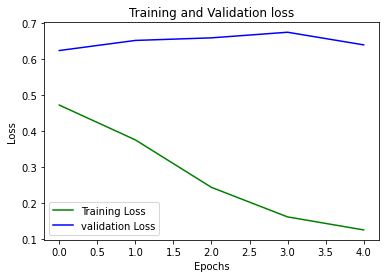

In [88]:
plot_loss('loss','val_loss')

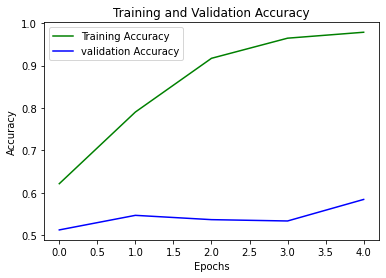

In [89]:
plot_accuracy('acc','val_acc')

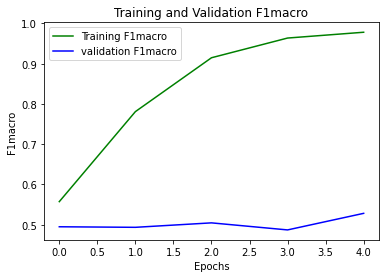

In [90]:
plot_f1macro('f1macro','val_f1macro')

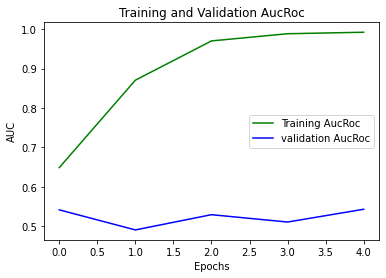

In [91]:
plot_Aucroc('auc','val_auc')

## For 30 Days

In [92]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","NASDAQ"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","NASDAQ"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "NASDAQ")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 30, 32)            14720     
                                                                 
 dropout_34 (Dropout)        (None, 30, 32)            0         
                                                                 
 lstm_35 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_34 (Dense)            (None, 16)                272       
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-tra

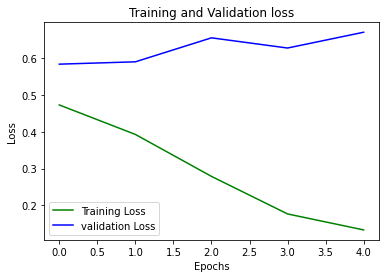

In [93]:
plot_loss('loss','val_loss')

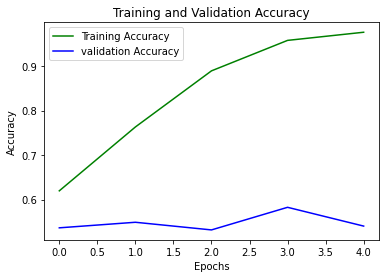

In [94]:
plot_accuracy('acc','val_acc')

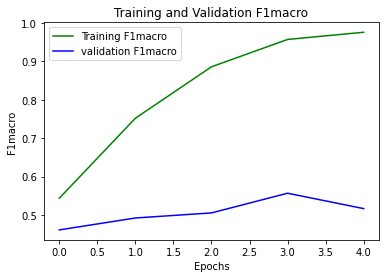

In [95]:
plot_f1macro('f1macro','val_f1macro')

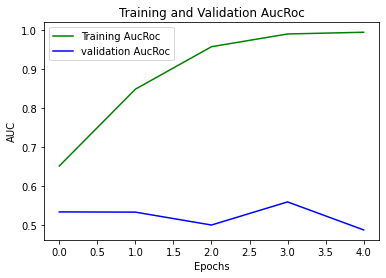

In [96]:
plot_Aucroc('auc','val_auc')

## For 20 Days

In [3]:
DATADIR = "/content/"
TRAIN_TEST_CUTOFF = '2016-04-21'
TRAIN_VALID_RATIO = 0.75

# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# to implement F1 score for validation in a batch
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

def lstm_model(seq_len=60, n_features=82):
    "2D-CNNpred model according to the paper"
    model = Sequential([
        Input(shape=(seq_len,n_features)),
        #Conv2D(8, kernel_size=(1, n_features), activation="relu"),
        #MaxPool2D(pool_size=(2,1)),
        #Flatten(),
        LSTM(32, activation="relu",return_sequences=True),
        Dropout(0.4),
        LSTM(16, activation="relu"),
        Dropout(0.4),
        Dense(16,activation="relu"),
        #Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])
    return model

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def datagen(data, seq_len, batch_size, targetcol, kind, key):
    "As a generator to produce samples for Keras model"
    batch = []
    while True:
        # Pick one dataframe from the pool
        #key = random.choice(list(data.keys()))
        df = data[key]
        input_cols = [c for c in df.columns if c != targetcol]
        index = df.index[df.index < TRAIN_TEST_CUTOFF]
        split = int(len(index) * TRAIN_VALID_RATIO)
        assert split > seq_len, "Training data too small for sequence length {}".format(seq_len)
        if kind == 'train':
            index = index[:split]   # range for the training set
        elif kind == 'valid':
            index = index[split:]   # range for the validation set
        else:
            raise NotImplementedError
        # Pick one position, then clip a sequence length
        while True:
            t = random.choice(index)     # pick one time step
            n = (df.index == t).argmax() # find its position in the dataframe
            if n-seq_len+1 < 0:
                continue # this sample is not enough for one sequence length
            frame = df.iloc[n-seq_len+1:n+1]
            batch.append([frame[input_cols].values, df.loc[t, targetcol]])
            break
        # if we get enough for a batch, dispatch
        if len(batch) == batch_size:
            X, y = zip(*batch)
            X, y = np.expand_dims(np.array(X), 3), np.array(y)
            yield X.reshape((X.shape[0],X.shape[1],82)), y.astype(np.float)
            batch = []

def testgen(data, seq_len, targetcol, key):
    "Return array of all test samples"
    batch = []
    df = data[key]
    #for key, df in data.items():
    input_cols = [c for c in df.columns if c != targetcol]
    # find the start of test sample
    t = df.index[df.index >= TRAIN_TEST_CUTOFF][0]
    n = (df.index == t).argmax()
    # extract sample using a sliding window
    for i in range(n+1, len(df)+1):
        frame = df.iloc[i-seq_len:i]
        batch.append([frame[input_cols].values, frame[targetcol][-1]])
    X, y = zip(*batch)
    #return np.expand_dims(np.array(X),3), np.array(y)
    X, y = np.expand_dims(np.array(X), 3), np.array(y)
    #print(X.shape)
    return X.reshape((X.shape[0],X.shape[1],82)), y.astype(np.float)

# Read data into pandas DataFrames
data = {}
for filename in os.listdir('/content/'):
    if not filename.lower().endswith(".csv"):
        continue # read only the CSV files
    filepath = os.path.join('/content/', filename)
    X = pd.read_csv(filepath, index_col="Date", parse_dates=True)
    # basic preprocessing: get the name, the classification
    # Save the target variable as a column in dataframe for easier dropna()
    name = X["Name"][0]
    del X["Name"]
    cols = X.columns
    X["Target"] = (X["Close"].pct_change().shift(-1) > 0).astype(int)
    X.dropna(inplace=True)
    # Fit the standard scaler using the training dataset
    index = X.index[X.index < TRAIN_TEST_CUTOFF]
    index = index[:int(len(index) * TRAIN_VALID_RATIO)]
    scaler = StandardScaler().fit(X.loc[index, cols])
    # Save scale transformed dataframe
    X[cols] = scaler.transform(X[cols])
    data[name] = X

# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5
n_features = 82

Aucroc = tf.keras.metrics.AUC(curve="ROC")
# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","NASDAQ"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","NASDAQ"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "NASDAQ")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 32)            14720     
                                                                 
 dropout_2 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 92s 221ms/step - loss: 0.4724 - acc: 0.6243 - auc: 0.6583 - f1macro: 0.5617 - val_loss: 0.6092 - val_acc: 0.4992 - val_auc: 0.5744 - val_f1macro: 0.4706
Epoch 2/5
400/400 [==============================] - 79s 199ms/step - loss: 0.3871 - acc: 0.7783 - auc: 0.8539 - f1macro: 0.7677 - val_loss: 0.6321 - val_acc: 0.5227 - val_auc: 0.5166 - val_f1macro: 0.5176
Epoch 3/5
400/400 [==============================] - 79s 199ms/step - loss: 0.2878 - acc: 0.8818 - auc: 0.9504 - f1macro: 0.8771 - val_loss: 0.6403 - val_acc: 0.5547 - val_auc: 0.5366 - val_f1macro: 0.5515
Epoch 4/5
400/400 [==============================] - 80s 200ms/step - loss: 0.2010 - acc: 0.9451 - auc: 0.9847 - f1macro: 0.9433 - val_loss: 0.6979 - val_acc: 0.4820 - val_auc: 0.4908 - val_f1macro: 0.4783
Epoch 5/5
400/400 [==============================] - 79s 198ms/step - loss: 0.1526 - acc: 0.9686 - auc: 0.9912 - f1macro: 0.9675 - val_loss: 0.6514 - val_acc: 0.5500 - val_auc: 0.5429 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


7/7 [==============================] - 0s 8ms/step
accuracy: 0.5317073170731708
RMSE: 0.4682926829268293
F1: 0.5596330275229358
Area under Curve:  0.5344959024204308


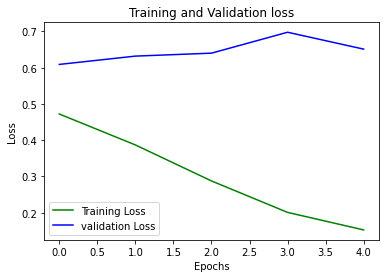

In [8]:
plot_loss('loss','val_loss')

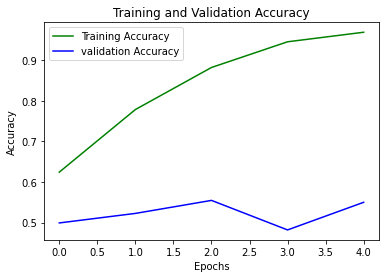

In [9]:
plot_accuracy('acc','val_acc')

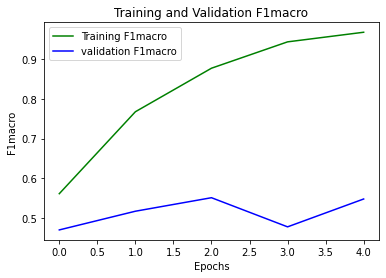

In [10]:
plot_f1macro('f1macro','val_f1macro')

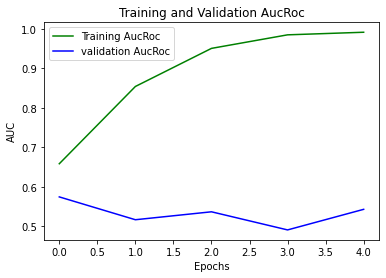

In [11]:
plot_Aucroc('auc','val_auc')

## For 10 Days

In [12]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5
n_features = 82


# Produce Lstm model as a binary classification problem
model = lstm_model(seq_len, n_features)
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=["acc",Aucroc, f1macro])
model.summary()  # print model structure to console

# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]

history = model.fit(datagen(data, seq_len, batch_size, "Target", "train","NASDAQ"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid","NASDAQ"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", "NASDAQ")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("RMSE:", mean_squared_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_pred,test_target, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 32)            14720     
                                                                 
 dropout_4 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 67s 163ms/step - loss: 0.4609 - acc: 0.6417 - auc: 0.6976 - f1macro: 0.6013 - val_loss: 0.6819 - val_acc: 0.4594 - val_auc: 0.5218 - val_f1macro: 0.4012
Epoch 2/5
400/400 [==============================] - 65s 163ms/step - loss: 0.3263 - acc: 0.8442 - auc: 0.9232 - f1macro: 0.8408 - val_loss: 0.6745 - val_acc: 0.5289 - val_auc: 0.5187 - val_f1macro: 0.5178
Epoch 3/5
400/400 [==============================] - 65s 163ms/step - loss: 0.2151 - acc: 0.9404 - auc: 0.9735 - f1macro: 0.9389 - val_loss: 0.6823 - val_acc: 0.5336 - val_auc: 0.5200 - val_f1macro: 0.5244
Epoch 4/5
400/400 [==============================] - 64s 160ms/step - loss: 0.1635 - acc: 0.9668 - auc: 0.9820 - f1macro: 0.9659 - val_loss: 0.6784 - val_acc: 0.5352 - val_auc: 0.5237 - val_f1macro: 0.5148
Epoch 5/5
400/400 [==============================] - 64s 160ms/step - loss: 0.1520 - acc: 0.9698 - auc: 0.9808 - f1macro: 0.9691 - val_loss: 0.6564 - val_acc: 0.5648 - val_auc: 0.5511 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


7/7 [==============================] - 0s 5ms/step
accuracy: 0.5365853658536586
RMSE: 0.4634146341463415
F1: 0.6885245901639345
Area under Curve:  0.41383701188455013


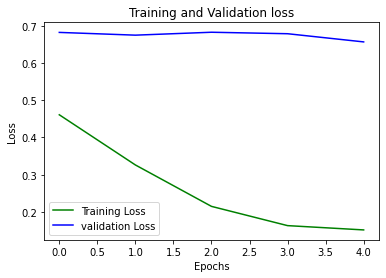

In [13]:
plot_loss('loss','val_loss')

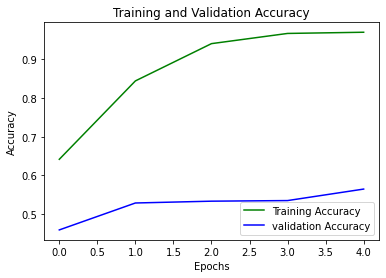

In [14]:
plot_accuracy('acc','val_acc')

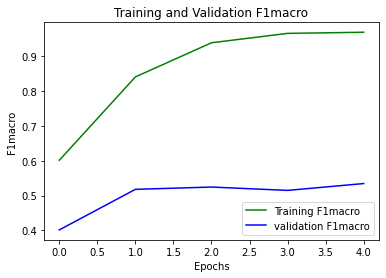

In [15]:
plot_f1macro('f1macro','val_f1macro')

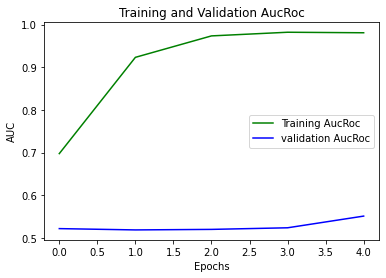

In [16]:
plot_Aucroc('auc','val_auc')